# Spotilyser: Mood Prediction based on user's Spotify Listening History

In [1]:
import requests
import pandas as pd

### Generate an access token to use the API

In [2]:
def getAccessToken():
    auth_url = 'https://accounts.spotify.com/api/token'
    clientID = "204d99eaea4044d08a4d5c06444cb58a"
    clientSecret = "ac11837bbd6e410da35bcbd3a1b05a7c"

    data = {
        'grant_type': 'client_credentials',
        'client_id': clientID,
        'client_secret': clientSecret,
    }

    auth_response = requests.post(auth_url, data = data)
    access_token = auth_response.json().get('access_token')
    return access_token

### Getting the audio features of a song given its name

In [3]:
def getAudioID(name):
  endpoint = "https://api.spotify.com/v1/search?q=track:" + name + "&type=track"

  headers = {
        'Authorization': 'Bearer {}'.format(getAccessToken())
    }

  response = requests.get(endpoint, headers = headers)
  if len(response.json().get('tracks').get('items')) != 0 and response.json() is not None:
    return response.json().get('tracks').get('items')[0].get('id')
  else:
    return 'noIDfound'
  # print(response.json())

getAudioID("The Hills")

'7fBv7CLKzipRk6EC6TWHOB'

In [4]:
def getAudioFeatures(id):
  endpoint = "https://api.spotify.com/v1/audio-features/" + id

  headers = {
        'Authorization': 'Bearer {}'.format(getAccessToken())
    }

  response = requests.get(endpoint, headers = headers)

  return response.json()

getAudioFeatures('7fBv7CLKzipRk6EC6TWHOB')

{'danceability': 0.585,
 'energy': 0.564,
 'key': 0,
 'loudness': -7.063,
 'mode': 0,
 'speechiness': 0.0515,
 'acousticness': 0.0671,
 'instrumentalness': 0,
 'liveness': 0.135,
 'valence': 0.137,
 'tempo': 113.003,
 'type': 'audio_features',
 'id': '7fBv7CLKzipRk6EC6TWHOB',
 'uri': 'spotify:track:7fBv7CLKzipRk6EC6TWHOB',
 'track_href': 'https://api.spotify.com/v1/tracks/7fBv7CLKzipRk6EC6TWHOB',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/7fBv7CLKzipRk6EC6TWHOB',
 'duration_ms': 242253,
 'time_signature': 4}

### Loading the StreamingHistory files and create a dataframe with each song's audio features

In [5]:
# df1 = pd.read_json("StreamingHistory0.json", encoding='utf-8')
# df2 = pd.read_json("StreamingHistory1.json", encoding='utf-8')
# df3 = pd.read_json("StreamingHistory2.json", encoding='utf-8')
# df4 = pd.read_json("StreamingHistory3.json", encoding='utf-8')
df5 = pd.read_json("StreamingHistory4.json", encoding='utf-8')
df = pd.concat([df5], ignore_index=True)
df.head()

,endTime,artistName,trackName,msPlayed
0,2022-02-08 19:42,The Weeknd,The Morning,312426
1,2022-02-08 19:45,The Weeknd,Sacrifice,188918
2,2022-02-08 19:50,The Weeknd,Faith,283226
3,2022-02-08 19:55,The Weeknd,Wicked Games,323746
4,2022-02-08 20:00,Lana Del Rey,Lust For Life (with The Weeknd),264066


In [8]:
tracks = df['trackName'].tolist()
audioFeatures = list(map(getAudioFeatures, list(map(getAudioID, tracks[0:500]))))
print(len(audioFeatures))

500


In [9]:
acousticness = []
danceability = []
liveness = []
loudness = []
speechiness = []
valence = []
tempo = []

for i in audioFeatures:
  acousticness.append(i.get('acousticness'))
  danceability.append(i.get('danceability'))
  liveness.append(i.get('liveness'))
  loudness.append(i.get('loudness'))
  speechiness.append(i.get('speechiness'))
  valence.append(i.get('valence'))
  tempo.append(i.get('tempo'))

songs = pd.DataFrame(list(zip(tracks, acousticness, danceability, liveness, loudness, speechiness, valence, tempo)), columns=['Song', 'Acousticness', 'Danceability', 'Liveness', 'Loudness', 'Speechiness', 'Valence', 'Tempo'])
songs.head()

,Song,Acousticness,Danceability,Liveness,Loudness,Speechiness,Valence,Tempo
0,The Morning,0.31700,0.652,0.1040,-7.555,0.0390,0.186,120.073
1,Sacrifice,0.02960,0.735,0.0678,-6.523,0.1130,0.905,122.000
2,Faith,0.09790,0.202,0.1090,-5.212,0.0324,0.252,85.040
3,Wicked Games,0.00959,0.658,0.3250,-5.197,0.0309,0.326,114.078
4,Lust For Life (with The Weeknd),0.60400,0.504,0.3640,-8.644,0.0542,0.262,99.982


In [10]:
# loudness and tempo audio features need to be scaled so as they lie within the range 0-1
from sklearn import preprocessing
import numpy

arrl = numpy.array(loudness)
arrt = numpy.array(tempo)
min_max_scaler = preprocessing.MinMaxScaler()
loudness_scaled = min_max_scaler.fit_transform(arrl.reshape(-1,1))
tempo_scaled = min_max_scaler.fit_transform(arrt.reshape(-1,1))
songs['Loudness'] = pd.DataFrame(loudness_scaled)
songs['Tempo'] = pd.DataFrame(tempo_scaled)
songs.dropna(inplace=True)
songs.head()

,Song,Acousticness,Danceability,Liveness,Loudness,Speechiness,Valence,Tempo
0,The Morning,0.31700,0.652,0.1040,0.808312,0.0390,0.186,0.428750
1,Sacrifice,0.02960,0.735,0.0678,0.836420,0.1130,0.905,0.441849
2,Faith,0.09790,0.202,0.1090,0.872127,0.0324,0.252,0.190618
3,Wicked Games,0.00959,0.658,0.3250,0.872535,0.0309,0.326,0.388000
4,Lust For Life (with The Weeknd),0.60400,0.504,0.3640,0.778652,0.0542,0.262,0.292184


### Choosing the most appropriate audio features

array([[<AxesSubplot:title={'center':'Acousticness'}>,
        <AxesSubplot:title={'center':'Danceability'}>,
        <AxesSubplot:title={'center':'Liveness'}>],
       [<AxesSubplot:title={'center':'Loudness'}>,
        <AxesSubplot:title={'center':'Speechiness'}>,
        <AxesSubplot:title={'center':'Valence'}>],
       [<AxesSubplot:title={'center':'Tempo'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

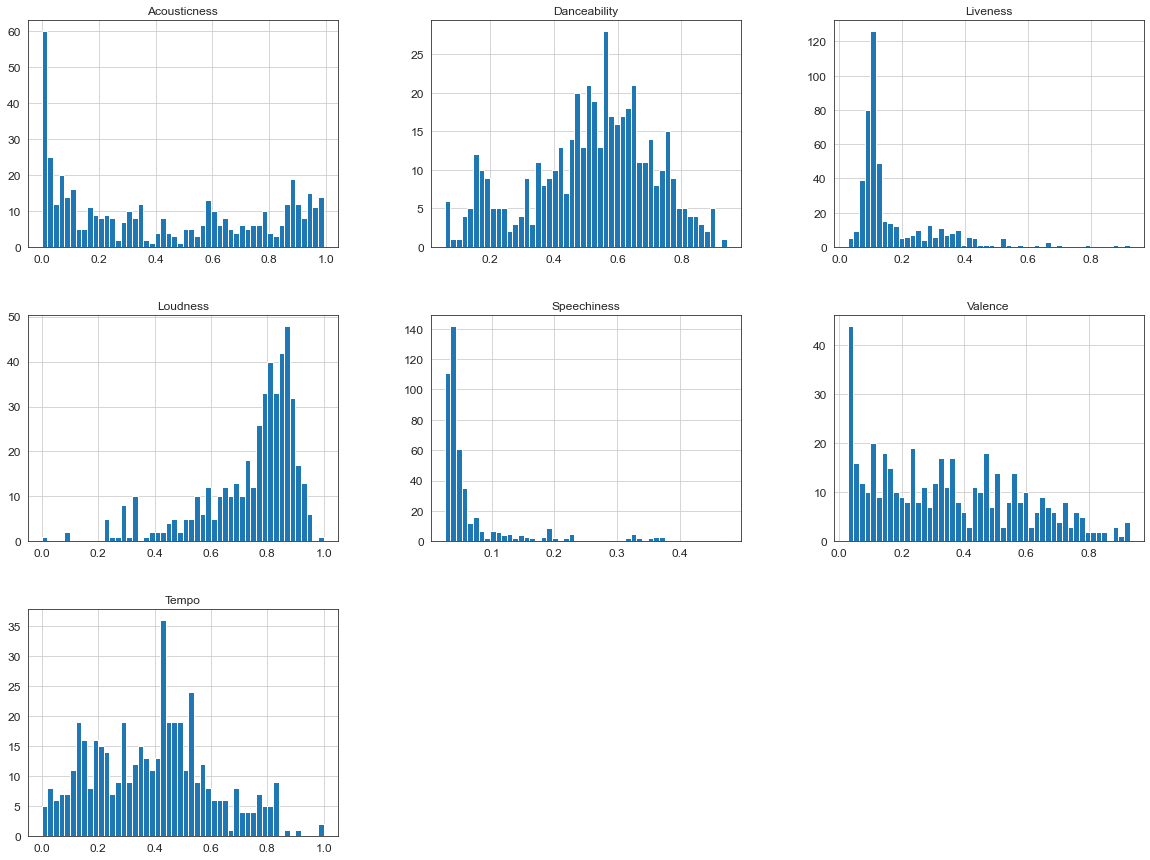

In [11]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import seaborn as sns
#set style of plots
sns.set_style('white')

songs.hist(bins=50,figsize=(20,15))

In [12]:
# drop tempo since it has high variance
song_features = songs.drop(['Song', 'Tempo', ],axis=1)
song_features.head()

,Acousticness,Danceability,Liveness,Loudness,Speechiness,Valence
0,0.31700,0.652,0.1040,0.808312,0.0390,0.186
1,0.02960,0.735,0.0678,0.836420,0.1130,0.905
2,0.09790,0.202,0.1090,0.872127,0.0324,0.252
3,0.00959,0.658,0.3250,0.872535,0.0309,0.326
4,0.60400,0.504,0.3640,0.778652,0.0542,0.262


### Clustering songs into moods

In [13]:
# finding appropriate number of mood clusters
from sklearn.cluster import KMeans

Sum_of_squared_distances = []
K = range(1,15)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(song_features)
    Sum_of_squared_distances.append(km.inertia_)

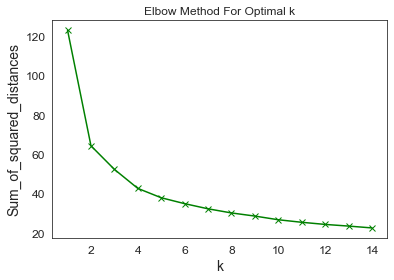

In [14]:
from sklearn.metrics import silhouette_score
for n_clusters in range(2,15):
    clusterer = KMeans (n_clusters=n_clusters)
    preds = clusterer.fit_predict(song_features)
    centers = clusterer.cluster_centers_

    score = silhouette_score (song_features, preds, metric='euclidean')

plt.plot(K, Sum_of_squared_distances, 'gx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [15]:
#optimal number of clusters is 3
kmeans = KMeans(n_clusters=3)
kmeans.fit(song_features)

KMeans(n_clusters=3)

### Visualising the Clusters using PCA

In [16]:
from sklearn.decomposition import PCA
y_kmeans = kmeans.predict(song_features)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(song_features)

C:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\regression.py:592: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


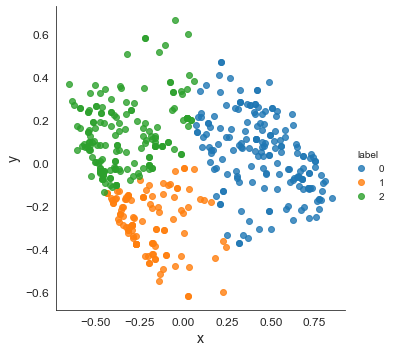

In [17]:
pc = pd.DataFrame(principal_components)
pc['label'] = y_kmeans
pc.columns = ['x', 'y','label']

#plot data with seaborn
cluster = sns.lmplot(data=pc, x='x', y='y', hue='label', 
                   fit_reg=False, legend=True, legend_out=True)

In [18]:
pca.explained_variance_ratio_

array([0.61134208, 0.19242802])

In [19]:
print(pd.DataFrame(pca.components_,columns=song_features.columns,index = ['PC-1','PC-2']))

      Acousticness  Danceability  Liveness  Loudness  Speechiness   Valence
PC-1      0.797763     -0.303218 -0.074997 -0.325662    -0.061552 -0.395176
PC-2      0.559534      0.472629  0.025924  0.101942     0.042990  0.671291


### Labelling each cluster into different moods by inspecting the songs in each cluster

In [20]:
songs['label'] = y_kmeans

# shuffle dataset
songs = songs.sample(frac=1)
songs['label'].value_counts()

0    177
2    177
1    112
Name: label, dtype: int64

In [26]:
songs[songs['label'] == 0].tail(20)

,Song,Acousticness,Danceability,Liveness,Loudness,Speechiness,Valence,Tempo,label
271,Never Meant To Belong (Bleach),0.988,0.443,0.1020,0.317600,0.0440,0.0374,0.046304,0
305,Jo Bhi Main,0.580,0.558,0.1250,0.808149,0.0286,0.3940,0.536916,0
79,Muskurane - Romantic,0.628,0.567,0.1320,0.845299,0.0264,0.2170,0.305833,0
298,Jo Bhi Main,0.580,0.558,0.1250,0.808149,0.0286,0.3940,0.536916,0
35,Ceiling Games,0.907,0.234,0.1180,0.648791,0.0317,0.1180,0.022771,0
104,Mehrama,0.861,0.560,0.0985,0.768085,0.0334,0.3760,0.346597,0
194,Wanted,0.902,0.704,0.1060,0.620411,0.0994,0.2430,0.428295,0
379,Before You Go,0.604,0.459,0.0885,0.881768,0.0573,0.1830,0.373066,0
338,Take Me To Church,0.634,0.566,0.1160,0.869648,0.0464,0.4370,0.489056,0
37,Peace and Purpose,0.931,0.154,0.2080,0.491530,0.0387,0.0396,0.160751,0


array([[<AxesSubplot:title={'center':'Acousticness'}>,
        <AxesSubplot:title={'center':'Danceability'}>,
        <AxesSubplot:title={'center':'Liveness'}>],
       [<AxesSubplot:title={'center':'Loudness'}>,
        <AxesSubplot:title={'center':'Speechiness'}>,
        <AxesSubplot:title={'center':'Valence'}>],
       [<AxesSubplot:title={'center':'Tempo'}>,
        <AxesSubplot:title={'center':'label'}>, <AxesSubplot:>]],
      dtype=object)

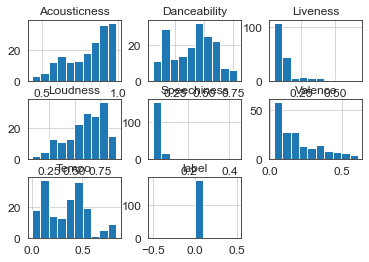

In [22]:
songs[songs['label']==0].hist()

In [23]:
songs[songs['label']==0].mean()

C:\Users\Hp\AppData\Local\Temp\ipykernel_18688\3587190627.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  songs[songs['label']==0].mean()


Acousticness    0.806079
Danceability    0.401988
Liveness        0.137685
Loudness        0.607028
Speechiness     0.050026
Valence         0.192280
Tempo           0.336918
label           0.000000
dtype: float64

In [33]:
songs[songs['label'] == 1].tail(20)

,Song,Acousticness,Danceability,Liveness,Loudness,Speechiness,Valence,Tempo,label
193,Thunder,0.000147,0.502,0.2170,0.873134,0.0364,0.2590,0.520154,1
410,Could You Love Me,0.311000,0.392,0.1240,0.927715,0.0782,0.3590,0.726420,1
84,Pal,0.035100,0.447,0.2430,0.790418,0.3230,0.2610,0.068701,1
214,Love Me Harder,0.009370,0.472,0.0764,0.894542,0.0334,0.2400,0.285455,1
5,Love Me Harder,0.009370,0.472,0.0764,0.894542,0.0334,0.2400,0.285455,1
285,You Get Me So High,0.186000,0.551,0.1520,0.847968,0.0542,0.3870,0.210983,1
295,"Love Me Like You Do - From ""Fifty Shades Of Grey""",0.247000,0.262,0.1250,0.833070,0.0484,0.2750,0.903097,1
155,Shinzo wo Sasageyo!,0.220000,0.440,0.2600,0.895332,0.0868,0.2030,0.699931,1
3,Wicked Games,0.009590,0.658,0.3250,0.872535,0.0309,0.3260,0.388000,1
326,Moth To A Flame (with The Weeknd),0.002700,0.553,0.1050,0.815394,0.0391,0.1050,0.429246,1


In [31]:
songs[songs['label'] == 2].head(20)

,Song,Acousticness,Danceability,Liveness,Loudness,Speechiness,Valence,Tempo,label
70,Channa Mereya,0.23700,0.476,0.1060,0.882776,0.0446,0.746,0.224782,2
245,On the Run,0.08320,0.479,0.1100,0.774240,0.0318,0.669,0.462010,2
237,Nachthimmel,0.35000,0.825,0.1110,0.715601,0.0445,0.314,0.326192,2
120,First Class,0.02540,0.905,0.1130,0.846988,0.1020,0.324,0.339875,2
420,Love You Like A Love Song,0.07610,0.858,0.0741,0.908677,0.0469,0.922,0.407923,2
348,The Way I Am,0.18100,0.731,0.3190,0.837264,0.1000,0.765,0.392629,2
446,I Love You So,0.58300,0.575,0.1150,0.880869,0.0358,0.466,0.129014,2
408,Love Is The Answer,0.13700,0.393,0.1340,0.631877,0.0428,0.624,0.987656,2
315,Stronger,0.00564,0.617,0.4080,0.800060,0.1530,0.490,0.319442,2
277,From the Grave,0.00137,0.585,0.8720,0.895713,0.1620,0.505,0.523879,2


##### Mood 1 - Sad; Mood 2 - Happy; Mood 3 - Romantic

### Predicting mood labels using RFC

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels

X = song_features
y = y_kmeans

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
rfc.fit(X_train,y_train)

RandomForestClassifier()

In [29]:
y_pred = rfc.predict(X_test)

In [34]:
import numpy as np
definitions = ['Sad','Energetic','Romantic']
reversefactor = dict(zip(range(4),definitions))
actual = np.vectorize(reversefactor.get)(y_test)
pred = np.vectorize(reversefactor.get)(y_pred)
print(pd.crosstab(actual, pred, rownames=['Actual Mood'], colnames=['Predicted Mood']))
cm = confusion_matrix(y_test, y_pred)
print(cm)

Predicted Mood  Energetic  Romantic  Sad
Actual Mood                             
Energetic              29         1    0
Romantic                3        61    2
Sad                     1         0   57
[[57  1  0]
 [ 0 29  1]
 [ 2  3 61]]


### Exporting and testing the model

In [37]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [39]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(rfc, open(filename, 'wb'))

In [35]:
song = getAudioFeatures(getAudioID("Tum Se Hi"))
#expected output: romantic

In [36]:
acousticness = [song.get('acousticness')]
danceability = [song.get('danceability')]
liveness = [song.get('liveness')]
loudness = [song.get('loudness')]
speechiness = [song.get('speechiness')]
valence = [song.get('valence')]

In [37]:
newSong = pd.DataFrame(list(zip(acousticness, danceability, liveness, loudness, speechiness, valence)), columns=['Acousticness', 'Danceability', 'Liveness', 'Loudness', 'Speechiness', 'Valence'])

In [38]:
y_pred = rfc.predict(newSong)
definitionsSong = ['Energetic','Romantic','Sad']
reversefactorSong = dict(zip(range(4),definitions))
predSong = np.vectorize(reversefactor.get)(y_pred)

In [39]:
predSong

array(['Romantic'], dtype='<U8')

In [40]:
newSong

,Acousticness,Danceability,Liveness,Loudness,Speechiness,Valence
0,0.328,0.609,0.125,-7.842,0.0273,0.608
